# Mathematical Foundations of Computer Graphics and Vision 2022
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. If using this notebook, please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems, buy you may create new cells should you find that necessary. 

In [13]:
%matplotlib inline
import math
from typing import Tuple, List
import itertools
from collections import namedtuple

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


# Defining objects to store Circle/Line objects
Circle = namedtuple("Circle", ["origin", "radius"])
Line = namedtuple("Line", ["a", "b"])

## Part 1: RANSAC for circle fitting

In [14]:
N = 100  # number of total points
D = 10  # half-domain size
R = 5  # radius of the default circle
tau = 0.1  # inlier distance threshold

### 1.1. Data generation

In [15]:
import math
import random
pi = math.pi

def PointsInCircum(r,n=100):
  inliers = []
  for i in range(n):
    angle = random.uniform(0,1)*math.pi*2 
    x = math.cos(angle)*r
    y = math.sin(angle)*r
    inliers.append([x,y])
  return inliers


In [16]:
def is_circle_inlier(points: np.ndarray, circle: Circle) -> np.ndarray:
    """
    points - Nx2 array with the data points
    circle - Circle object to test against
    
    Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
    """
    is_inlier = np.ones((points.shape[0],), dtype = bool)
    
    # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
    # Use `circle.origin` and `circle.radius` to access attributes of Circle
    # START


    for i in range(points.shape[0]):
      dis = np.linalg.norm(points[i] - circle.origin, ord=None, axis=None, keepdims=False)
      is_inlier[i] = True if abs(dis - circle.radius) <= tau else False

    # END
    
    return is_inlier


def generate_circle_points(r, n_points=N, circle: Circle = Circle((0, 0), R)) -> Tuple[np.ndarray, np.ndarray]:
    """
    r - outlier ratio
    n_points - number of points to generate
    circle - circle model for the inliers
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the respective points
    """
    n_outliers = int(n_points * r)
    n_inliers = n_points - n_outliers
    
    inliers = np.random.uniform(-D, D, (n_inliers, 2))
    outliers = np.random.uniform(-D, D, (n_outliers, 2))
    
    # TODO : Implement Task 1.1. You can use `is_circle_inlier` for that
    # START
   
    inliers = np.array(PointsInCircum(R, n_inliers)) +  np.random.uniform(-0.1, 0.1, inliers.shape)
    while is_circle_inlier(outliers,circle).all() != False:
      index = np.where(is_circle_inlier(outliers,circle) == True)
      for i in index[0]:
        outliers[i] = np.random.uniform(-D,D,(1,2))


    while is_circle_inlier(inliers,circle).all() != True:
      index2 = np.where(is_circle_inlier(inliers,circle) == False)
      for j in index2[0]:
        inliers[j] = np.array(PointsInCircum(R, 1)) +  np.random.uniform(-0.1, 0.1, (1,2))
    # END 

    
    return inliers, outliers

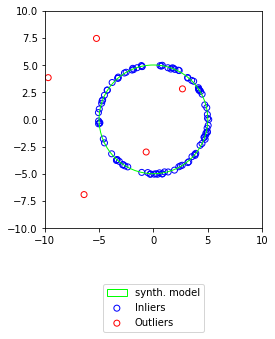

In [17]:
# Helper class to plot your results. No need to edit this, if `generate_circle_points` is implemented correctly
def plot_ransac_result(ax, inliers, outliers, ransac_model: Circle, synth_model: Circle):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    if ransac_model is not None:
        ransac_circle = plt.Circle(ransac_model.origin, ransac_model.radius, color='black', label='RANSAC model', fill=False)
        ax.add_patch(ransac_circle)
        
    synth_circle = plt.Circle(synth_model.origin, synth_model.radius, color='lime', label='synth. model', fill=False)
    ax.add_patch(synth_circle)
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers 
inliers, outliers = generate_circle_points(0.05)
fig, ax = plt.subplots()
plot_ransac_result(ax, inliers, outliers, None, Circle((0, 0), R))
plt.show()
plt.close(fig)

### 1.2. RANSAC

In [18]:
from math import sqrt
# Function to find the circle on
# which the given three points lie
def findCircle(points) :

  b = points[0]
  c = points[1]
  d = points[2]
    
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return cx,cy,radius

In [19]:
def fit_circle(points: np.ndarray) -> Circle:
    """
    points - 3x2 array
    
    Returns - Circle going through all the `points`
    """
    if points.shape != (3, 2):
        raise ValueError("Bad number of points")
    
    x = 0
    y = 0
    radius = 1
    
    # TODO : Compute circle origin (x, y) and radius that goes through all three `points`
    # START 

    x,y,radius = findCircle(points)
    
    # END 
    
    return Circle((x, y), radius)

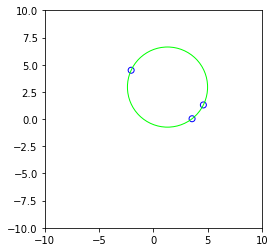

In [20]:
# Testing `fit_circle` implementation. No need to edit this
def plot_fitted_circle(points, circle: Circle):
    fig, ax = plt.subplots()
    plot_ransac_result(ax, points, points[:0], None, circle)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)
    
points = np.random.uniform(-D//2, D//2, (3, 2))
circle = fit_circle(points)

plot_fitted_circle(points, circle)

In [21]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate
    
    Returns - number of RANSAC iterations to achieve `p` success rate 
    """
    n = 1
    
    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START 

    n = math.ceil(math.log(1-p)/math.log(1-pow((1-r),sample_size)))

    # END 
    
    return n

In [22]:
import itertools as iter

In [23]:
def run_ransac(points: np.ndarray, n_iter: int) -> Tuple[np.ndarray, np.ndarray, Circle]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Circle model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    circle = None
    
    # TODO : Implement 1.2 - RANSAC for circle fitting
    # START
    n_inliers = 0

    combs = list(itertools.combinations(points,3))
    random.shuffle(combs)

    for i in range(n_iter):

      circle_iter = fit_circle(np.vstack(combs[i]))
      n_inliers_iter =  np.sum(is_circle_inlier(points,circle_iter))

      if n_inliers < n_inliers_iter:
        n_inliers = n_inliers_iter
        inliers = points[is_circle_inlier(points, circle_iter)]
        outliers = points[is_circle_inlier(points, circle_iter) == False]
        circle = circle_iter
      
    # END 
    
    return inliers, outliers, circle

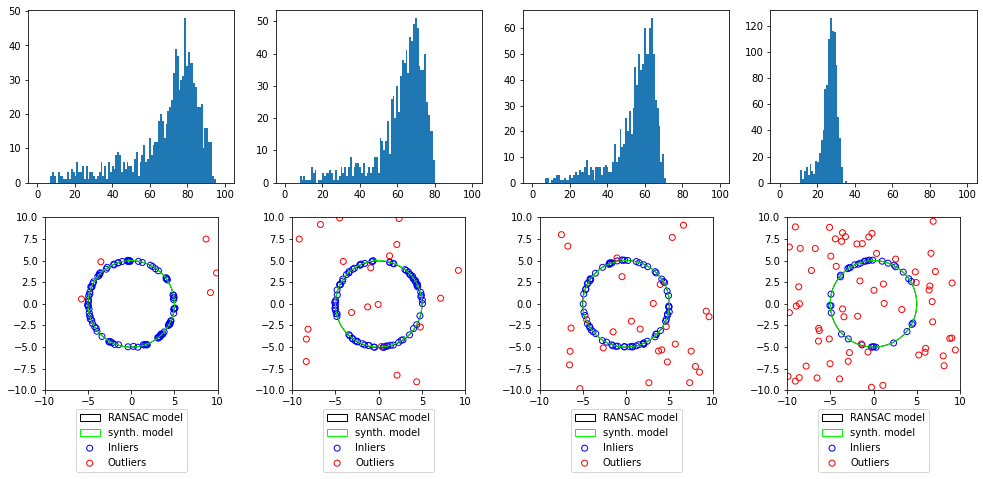

In [38]:
# Running RANSAC and populating historgrams
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))


for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)): 
    inlier_histogram = np.zeros(N_RUNS)
    
    ransac_inliers = None
    ransac_outliers = None
    circle = None
    
    # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
    #        `ransac_outliers`, `circle`
    # START
    

    iter_n = get_ransac_iterations(r, 3, 0.99)
    
    ransac_inlier_n = 0

    for i in range(N_RUNS):
      
      points = np.vstack((generate_circle_points(r, 100)))
      
      ransac_inliers_run, ransac_outliers_run, circle_run = run_ransac(points, iter_n)
      ransac_inlier_run_n = ransac_inliers_run.shape[0]

      inlier_histogram[i] = ransac_inlier_run_n

      if ransac_inlier_run_n > ransac_inlier_n:
        ransac_inlier_n = ransac_inlier_run_n
        ransac_inliers = ransac_inliers_run
        ransac_outliers = ransac_outliers_run
        circle = circle_run

    # END
    ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)
    
    plot_ransac_result(ax_vis, ransac_inliers, ransac_outliers, circle, Circle((0, 0), R))

plt.show()
plt.close(fig)

### 1.3. Exhaustive search

In [25]:
def exhaustive_search(points: np.ndarray) -> Tuple[np.ndarray, np.ndarray, Circle]:
    """
    points - Nx2 array with the data points
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best Circle model
    """

    n_points = points.shape[0]

    inliers = points[:0]
    outliers = points
    circle = None

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START
    combs = itertools.combinations(points,3)
    n_inliers = 0

    for i in combs:
      circle_exh = fit_circle(np.array(i))

      n_inliers_exh =  np.sum(is_circle_inlier(points,circle_exh))

      if n_inliers < n_inliers_exh:
        n_inliers = n_inliers_exh
        inliers = points[is_circle_inlier(points, circle_exh)]
        outliers = points[is_circle_inlier(points, circle_exh) == False]
        circle = circle_exh

    # END 
    
    return inliers, outliers, circle

Real inliers: 16
RANSAC inliers: 17
Exhaustive search inliers: 17


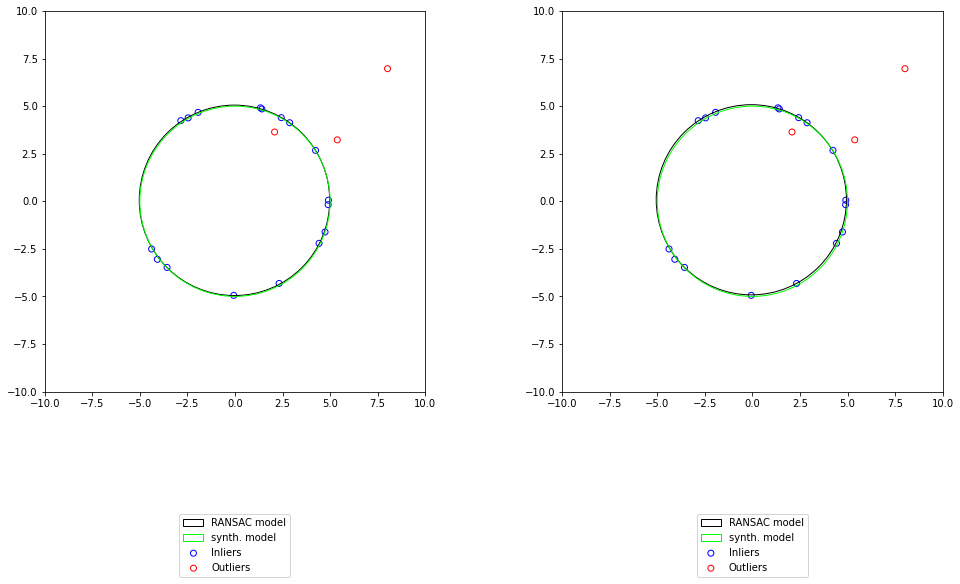

In [26]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = generate_circle_points(0.2, 20)
points = np.concatenate((inliers, outliers), 0)
n_iter = get_ransac_iterations(0.7, 3, 0.99)
ransac_inliers, ransac_outliers, circle = run_ransac(points, n_iter)

exhaustive_inliers, exhaustive_outliers, exhaustive_circle = exhaustive_search(points)

print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))
plot_ransac_result(axes[0], ransac_inliers, ransac_outliers, circle, Circle((0, 0), R))

plot_ransac_result(axes[1], exhaustive_inliers, exhaustive_outliers, exhaustive_circle, Circle((0, 0), R))
plt.show()
plt.close(fig)

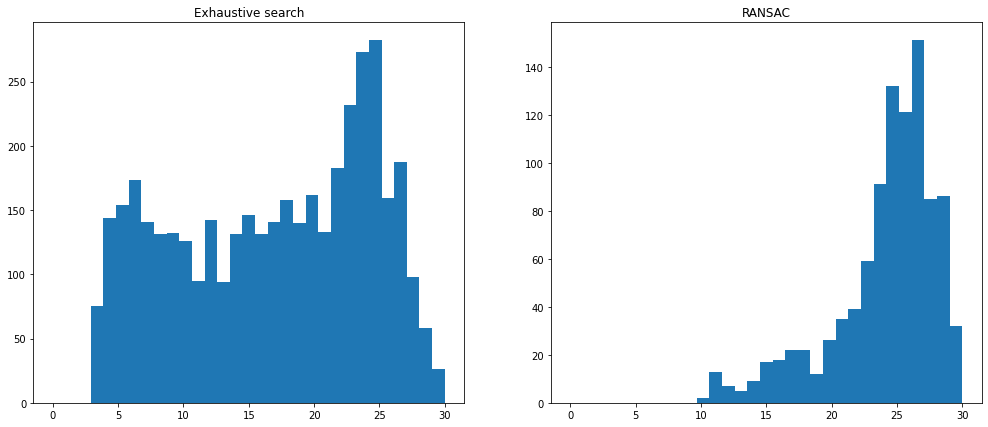

In [42]:
def exhaustive_search_histogram(inliers: np.ndarray, points: np.ndarray) -> List[int]:
    """
    inliers - Nx2 array with the true inliers from the synthetic model
    points - Nx2 array with the data points
    
    Returns - list of number of inliers for each of the samples
    """
    n_points = points.shape[0]
    
    nb_inliers_list = []
    
    # TODO : Populate `nb_inliers_list` by running exhaustive search on synthetic inliers
    #        and counting the number of found inliers in `points`
    # START

    combs = itertools.combinations(inliers,3)
    n_inliers = 0

    for i in combs:
      circle_exh = fit_circle(np.array(i))

      n_inliers_exh =  np.sum(is_circle_inlier(points,circle_exh))
      nb_inliers_list.append(n_inliers_exh)

    # END 
    
    return nb_inliers_list


def compare_ransac_and_exhaustive_search():
    r = 0.7
    inliers, outliers = generate_circle_points(r)
    points = np.concatenate((inliers, outliers), 0)
    
    exhaustive_histogram = exhaustive_search_histogram(inliers, points)
    
    ransac_histogram: List[int] = []
        
    # TODO : Populate `ransac_histogram` by running RANSAC 1000 times
    # START

    iter_n = get_ransac_iterations(r,3,0.99)

    for i in range(1000):
      
      ransac_inliers_run, ransac_outliers_run, circle_run = run_ransac(points, iter_n)
      ransac_inlier_run_n = ransac_inliers_run.shape[0]

      ransac_histogram.append(ransac_inlier_run_n) 

    # END

    # Plotting the results
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))
    
    axes[0].hist(np.array(exhaustive_histogram), range=(0, 30), bins=31)
    axes[0].set_title('Exhaustive search')

    axes[1].hist(np.array(ransac_histogram), range=(0, 30), bins=31)
    axes[1].set_title('RANSAC')


compare_ransac_and_exhaustive_search()

### Questions and Discussion 

<b style="color:red"> Question 1: </b> How many combinations (exhaustive search) exist for $N=100$ points? 

$C_{100}^{3}$ = $161700$

<b style="color:red"> Question 2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$? 

When fitting a circle ($sample size = 3$), the probability of success is $99\%$, the number of RANSAC iterations are $3, 7, 11, 169$ respectively.

<b style="color:red"> Question 3: </b> What about when $N=100,000$ points?

For exhuastive search, $C_{100,000}^{3}$ = $166661666700000$.

For RANSAC, the number of iterations doesn't change.

<b style="color:red"> Question 4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

No, it aslo hypothesizes only models supported by the samples.

<b style="color:red"> Question 5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations improve that?

NO. Because RANSAC only guarantee finding the samples are all inliers, which doesn't mean it would find the optimal model. 

YES. Increasing the number of RANSAC iterations improves it in general. Because with more iterations, RANSAC will find more suitable samples to fit the model.

<b style="color:red">Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.</b>

When the number of inliers are very large (we have many data points), the combination of them (samples) would also be a great amount. In this case, exhaustive research speed is lower than RANSAC(running 1000 times). But with small amount of data points, exhaustive research can perform better, i.e find the more number of synthesized inliers in reasonable time compared to RANSAC.

## Part 2: IRLS and norms for line fitting

In [28]:
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

TEST_LINE = Line(1, 1)

### Data generation

In [29]:
def is_line_inlier(points: np.ndarray, line: Line) -> np.ndarray:
    """
    points - Nx2 array with the data points
    line - Line object to test against
    
    Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
    """
    is_inlier = np.ones((points.shape[0],), dtype=bool)
    
    # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
    # Use `line.a` and `line.b` to access attributes of a line
    # START


    x = points[:,0]
    y = points[:,1]

    k = line.a
    h = line.b

    theDistance= abs((h+k*(x-0)-y)/(math.sqrt(k*k+1)))


    is_inlier = theDistance < tau

    # END
    
    return is_inlier
    

def generate_line_points(r: float, n_points=N, line: Line = TEST_LINE) -> np.ndarray:
    """
    r - outlier ratio
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the respective points
    """
    n_outliers = int(n_points * r)
    n_inliers = n_points - n_outliers
    
    inliers = np.random.uniform(-D, D, (n_inliers, 2))
    outliers = np.random.uniform(-D, D, (n_outliers, 2))
    
    # TODO : Implement data points generation, following similar strategy as in Part 1
    # START

    inliers[:,1] = inliers[:,0] * line.a + line.b + np.random.uniform(-0.1, 0.1, inliers.shape[0])

    while n_outliers >0 and is_line_inlier(outliers,line).all() != False:
      index = np.where(is_line_inlier(outliers,line) == True)
      for i in index[0]:
        outliers[i] = np.random.uniform(-D,D,(1,2))


    while is_line_inlier(inliers,line).all() != True:
      index2 = np.where(is_line_inlier(inliers,circle) == False)
      for j in index2[0]:
        inliers[j] = inliers[j,1] = inliers[j,0] * line.a + line.b + np.random.uniform(-0.1, 0.1, inliers.shape[0])

    # END 
    
    return np.concatenate((inliers, outliers), 0)

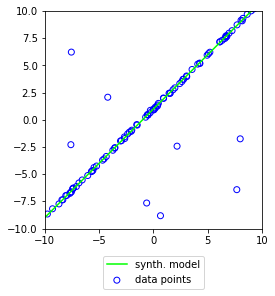

In [30]:
# Plotting the generated line, no need to change this code
def plot_line(ax, points, fitted_model: Line, synth_model: Line, title=None):
    def _plot_line(line: Line, label, color):
        x = np.linspace(-D, D, 100)
        y = line.a * x + line.b
        ax.plot(x, y, label=label, color=color)
        
    ax.scatter(points[:, 0], points[:, 1], label="data points", c='none', edgecolors='blue')
    
    if fitted_model is not None:
        _plot_line(fitted_model, 'fitted model', 'black')
        
    _plot_line(synth_model, 'synth. model', 'lime')
    
    if title is not None:
        ax.set_title(title)
        
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.3), loc="lower center")
    
points = generate_line_points(0.1)
fig, ax = plt.subplots()
plot_line(ax, points, None, Line(1, 1))
plt.show()
plt.close(fig)

In [31]:
from scipy.optimize import linprog

In [34]:
from numpy.ma.core import concatenate
from numpy.linalg import inv
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    line = Line(0.5, 0)
    
    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START
    X = np.c_[points[:,0],np.ones(points.shape[0])]
    y= points[:,1]
    n,p = X.shape

    tolerance = 0.0001
    W = np.identity(n)
    theta_new = np.array([0.5,0])
    diff = 100000
    
    while diff > tolerance:

      theta = theta_new

      W_ = abs(y - X.dot(theta))
      W_[W_ <0.001] = 0.001

      W_list = np.reciprocal(W_) 

      W =np.diag( W_list )
  
      theta_new = np.dot( inv( X.T.dot(W).dot(X) ), ( X.T.dot(W).dot(y) )) 
      diff = np.linalg.norm(theta - theta_new, ord=None, axis=None, keepdims=False)

    line = Line(theta[0],theta[1])

    # END
       

    return line


def fit_line_lp_l1(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """   
    line = Line(0.5, 0)

    # TODO : Implement line fitting with L-1 norm by using linear programming
    # START
    N = points.shape[0]

    c = np.ones(N+2)
    c[0] = 0
    c[1] = 0

    b_ub = np.concatenate( (points[:,1], -points[:,1]))

    a_ub = np.c_[(np.concatenate((points[:,0], -1 * points[:,0])),np.concatenate((np.ones(N),-np.ones(N))))]

    a_ub = np.concatenate((a_ub, np.concatenate((-np.identity(N),-np.identity(N)))), axis = 1 )


    L1_lp = linprog(c, a_ub , b_ub,options={'presolve':True,'lstsq' :True})

    line = Line( L1_lp.x[0], L1_lp.x[1])

    # END
    
    return line


def fit_line_lp_l_inf(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    line = Line(0.5, 0)
    
    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START
    N = points.shape[0]

    c = np.zeros(3)
    c[2] = 1

    b_ub = np.concatenate( (points[:,1], -points[:,1]))

    a_ub = np.c_[(np.concatenate((points[:,0], -1 * points[:,0])),np.concatenate((np.ones(N),-np.ones(N))))]

    a_ub = np.c_[(a_ub, np.concatenate((-np.ones(N),-np.ones(N)))) ]


    L1_lp = linprog(c, a_ub , b_ub,options={'presolve':True,'lstsq':True})

    line = Line( L1_lp.x[0], L1_lp.x[1])


    # END
    
    return line

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IRLS L1: Line(a=1.0008948157144626, b=0.9893257145031913)
LP L1: Line(a=1.0008099409189175, b=0.9890762666197078)
LP L-inf: Line(a=0.9996554722417627, b=0.9979347452236335)


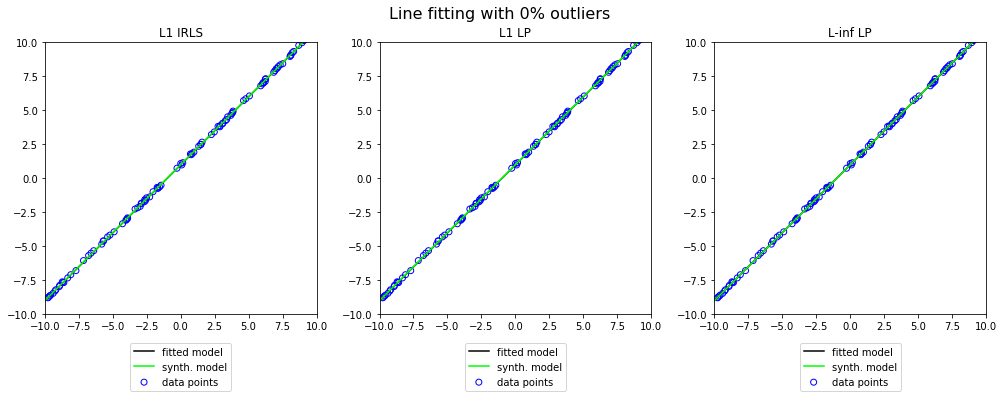

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IRLS L1: Line(a=0.9986796390123382, b=0.9941928520625269)
LP L1: Line(a=0.9986938455717547, b=0.9939449557219167)
LP L-inf: Line(a=1.444598321395644, b=1.5163649292655255e-12)


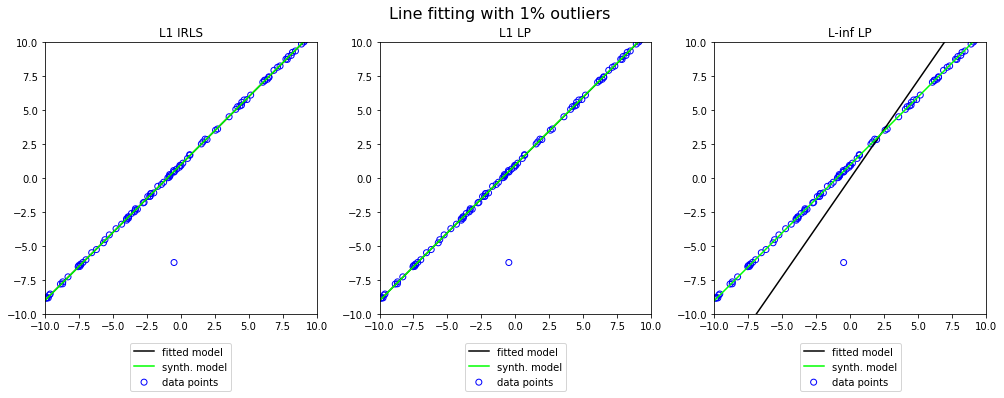

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IRLS L1: Line(a=0.9971749324473698, b=0.9904150171187265)
LP L1: Line(a=0.9974719536631489, b=0.9902646116906026)
LP L-inf: Line(a=0.05572472461008637, b=0.45269505807054)


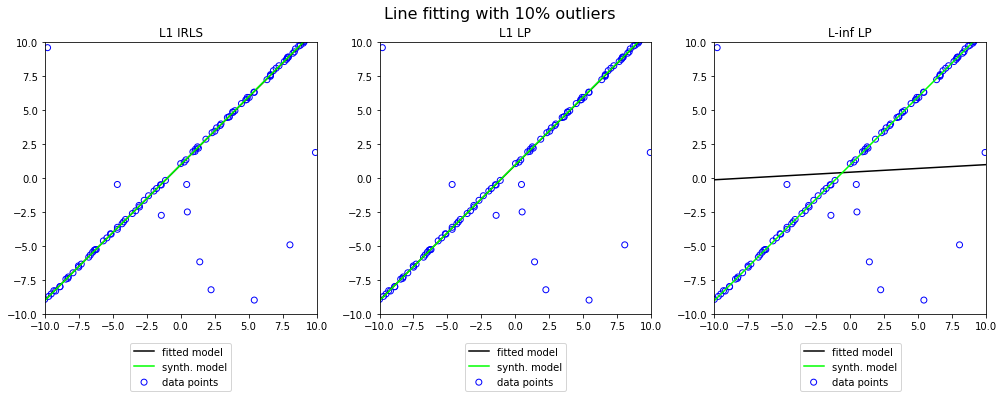

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IRLS L1: Line(a=0.9916552120383151, b=1.0312023695655825)
LP L1: Line(a=0.9916098409871834, b=1.031109462724239)
LP L-inf: Line(a=0.043979141882726135, b=0.3225067991668382)


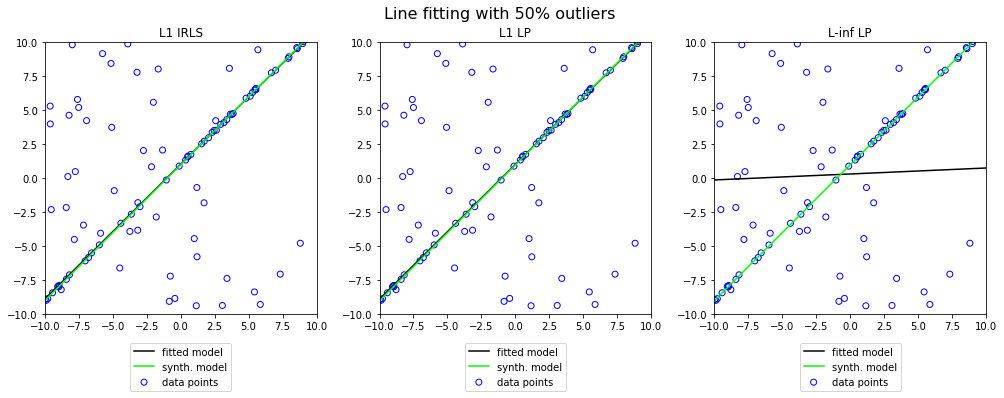

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IRLS L1: Line(a=0.20611556557844896, b=-0.9861362434754031)
LP L1: Line(a=0.14814460234570104, b=1.8595179999004813e-09)
LP L-inf: Line(a=0.04328012993031518, b=0.08222083392413836)


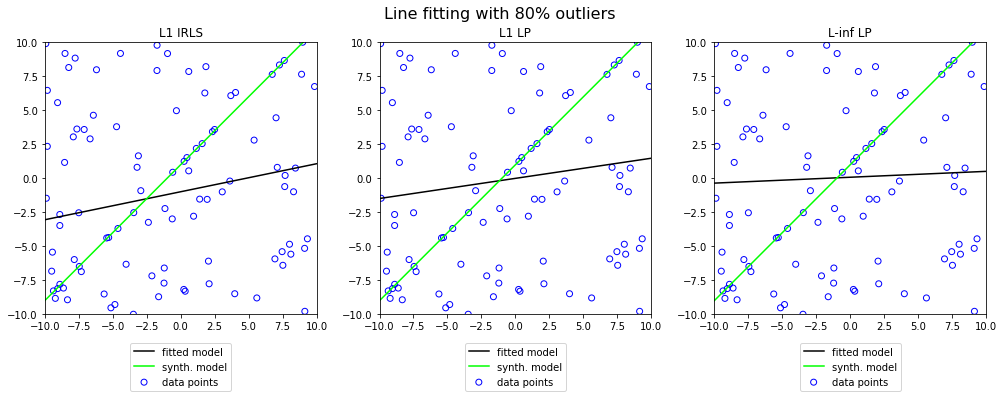

In [37]:
# Plotting the results. No need to change this code
for r in [0, 0.01, 0.1, 0.5, 0.8]:
    points = generate_line_points(r)
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)

    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")

    plot_line(axes[0], points, irls_l1_line, Line(1, 1), title="L1 IRLS")
    plot_line(axes[1], points, lp_l1_line, Line(1, 1), title="L1 LP")
    plot_line(axes[2], points, lp_l_inf_line, Line(1, 1), title="L-inf LP")
    
    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
    plt.show()
    plt.close(fig)

### Discussion 

<b style="color:red">Discuss the results obtained by these methods</b>

L1 IRLS and L1 LP both fits the synthetic line when the number of outliers ara less than 50% of total number of data points. When the oulier rate is 80%,the line doesn't fit well any more, only with some rough direction. However, The $L_\infty$ norm LP totally depends on the minimum of the maximum distance. So the positions of outliers influence a lot.